In [33]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from PIL import Image 
from tensorflow.keras.utils import load_img
import pathlib
from keras.utils import to_categorical
import pandas as pd
import seaborn as sns
from tensorflow.keras import regularizers

In [2]:
dataset_path = './Dataset'

In [3]:
img_height = 128
img_width = 128
race = ['White','Black','Asian','Indian','Others']
gender = ['Male','Female']

gender_map = {
    0: "Male",
    1: "Female"
}

race_map = {
    0 : 'White',
    1: 'Black',
    2: 'Asian',
    3: 'Indian',
    4: 'Other',
}


# Creating DataFrame with all images

In [4]:
import random
image_filenames = os.listdir(dataset_path)
random.shuffle(image_filenames)

In [5]:
def extract_features(filename):
    age,gender,race,_ = filename.split('_')
    return (int(age),int(gender),int(race),filename)


In [6]:
feature = [extract_features(filename) for filename in image_filenames]
df = pd.DataFrame(feature, columns=['Age','Gender','Race','Image'])
df.head()

,Age,Gender,Race,Image
0,29,1,1,29_1_1_20170115234825058.jpg
1,30,1,0,30_1_0_20170117143123552.jpg
2,27,0,1,27_0_1_20170113133402529.jpg
3,26,0,3,26_0_3_20170119180530883.jpg
4,30,0,1,30_0_1_20170104170359625.jpg


### Number of images

In [7]:
print(len(df))

17475


In [8]:
df.describe(include='all')

,Age,Gender,Race,Image
count,17475.000000,17475.000000,17475.000000,17475
unique,NaN,NaN,NaN,17475
top,NaN,NaN,NaN,29_1_1_20170115234825058.jpg
freq,NaN,NaN,NaN,1
mean,36.413677,0.476338,1.453047,NaN
std,16.722907,0.499454,1.326563,NaN
min,1.000000,0.000000,0.000000,NaN
25%,26.000000,0.000000,0.000000,NaN
50%,31.000000,0.000000,1.000000,NaN
75%,45.000000,1.000000,3.000000,NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17475 entries, 0 to 17474
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Age     17475 non-null  int64 
 1   Gender  17475 non-null  int64 
 2   Race    17475 non-null  int64 
 3   Image   17475 non-null  object
dtypes: int64(3), object(1)
memory usage: 546.2+ KB


# Explorary data analysis

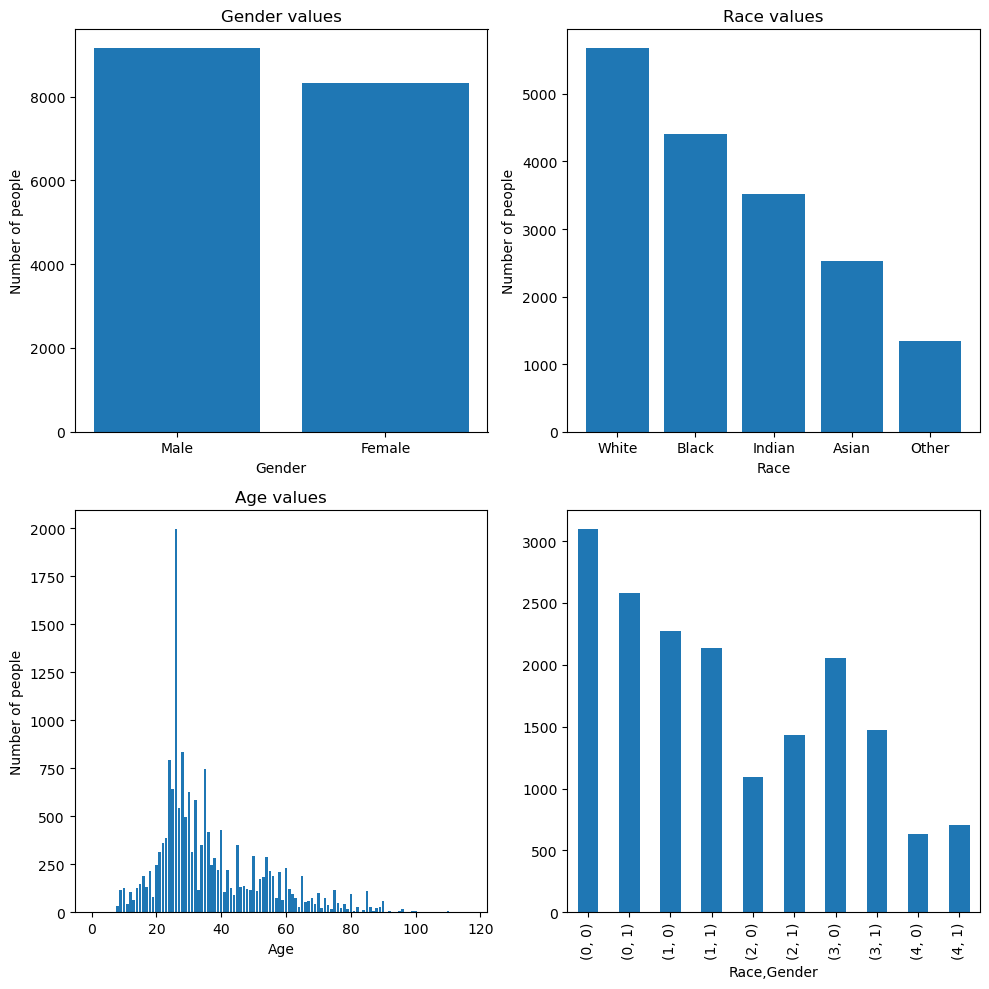

In [10]:
gender_counts = df['Gender'].value_counts()
race_counts = df['Race'].value_counts()
age_counts = df['Age'].value_counts()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))  

axs[0][0].bar(gender_counts.index.map(gender_map), gender_counts.values)
axs[0][0].set_title('Gender values')
axs[0][0].set_xlabel('Gender')
axs[0][0].set_ylabel('Number of people')

axs[0][1].bar(race_counts.index.map(race_map), race_counts.values)
axs[0][1].set_title('Race values')
axs[0][1].set_xlabel('Race')
axs[0][1].set_ylabel('Number of people')

axs[1][0].bar(age_counts.index,age_counts.values)
axs[1][0].set_title('Age values')
axs[1][0].set_xlabel('Age')
axs[1][0].set_ylabel('Number of people')

axs[1][1] = df.groupby(by=['Race','Gender'])[['Race','Gender']].value_counts().plot(kind='bar')

plt.tight_layout()  
plt.show()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17475 entries, 0 to 17474
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Age     17475 non-null  int64 
 1   Gender  17475 non-null  int64 
 2   Race    17475 non-null  int64 
 3   Image   17475 non-null  object
dtypes: int64(3), object(1)
memory usage: 546.2+ KB


### Removing outliners

In [12]:
df = df[df['Age'] < 95]
df = df[df['Age'] > 4]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17420 entries, 0 to 17474
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Age     17420 non-null  int64 
 1   Gender  17420 non-null  int64 
 2   Race    17420 non-null  int64 
 3   Image   17420 non-null  object
dtypes: int64(3), object(1)
memory usage: 680.5+ KB


<BarContainer object of 89 artists>

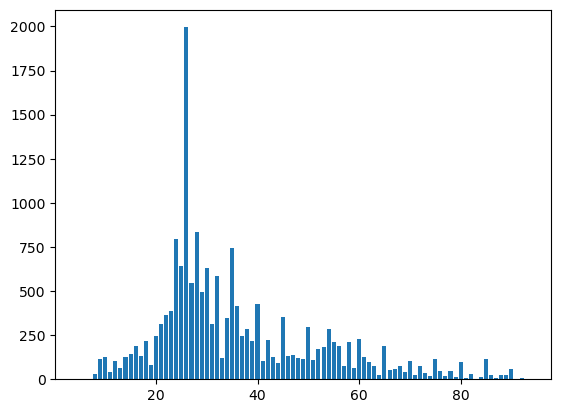

In [14]:
age_counts = df['Age'].value_counts()
plt.bar(age_counts.index,age_counts.values)

## Few example images

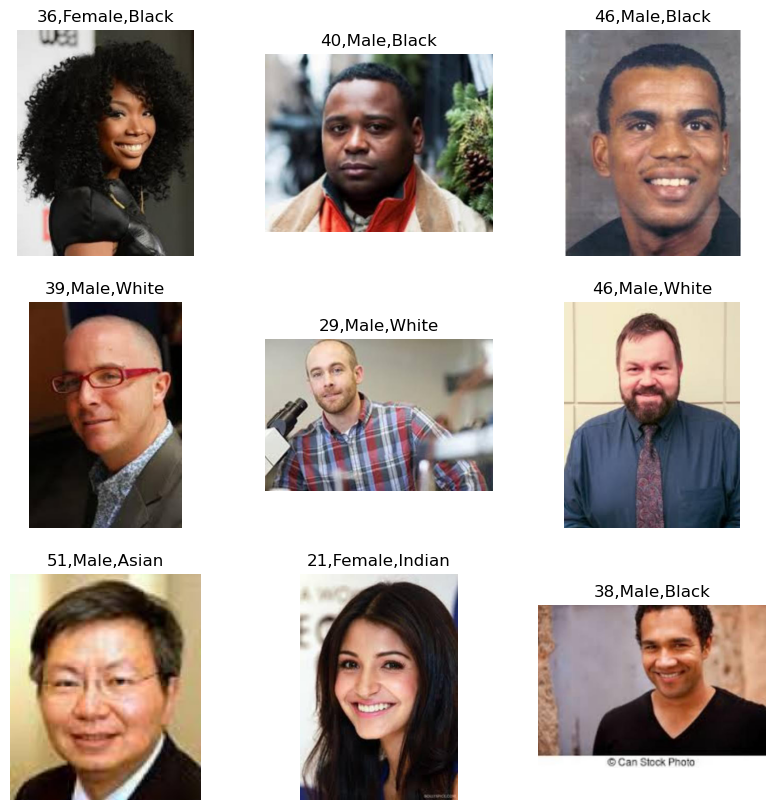

In [15]:
plt.figure(figsize=(10,10))
for i in range(9):
    random_index = random.randint(0,len(df))
    ax = plt.subplot(3,3,i+1)
    df_row = df.iloc[random_index]
    img = Image.open(os.path.join(dataset_path,df_row['Image']))
    plt.title(f"{df_row['Age']},{gender_map[df_row['Gender']]},{race_map[df_row['Race']]}")
    plt.axis('off')
    plt.imshow(img)

# Data pre-processing


### Spliting data to training and testing set

In [17]:
from sklearn.model_selection import train_test_split

df_train,df_test = train_test_split(df,test_size=0.003,random_state=42)
print(len(df_train))
print(len(df_test))



17367
53


## Creating numpy array of images as array, race label, gender label and gender label
### Resizing and scaling the photo so that the values ​​are in the range [0,1]
### Scaling race and gender as one hot encoding

In [18]:
def load_images(img_width,img_height,dataset_path,df):
    images = list()
    age_label = []
    gender_label = []
    race_label = []
    for i,row in enumerate(df.values):
        age_label.append((int(row[0])/ 93))
        gender_label.append(to_categorical((row[1]),len(gender)))
        race_label.append(to_categorical((row[2]),len(race)))
        img = Image.open(os.path.join(dataset_path, row[3]))
        img = img.resize((img_width,img_height))
        img = img.convert('RGB')
        img = np.array(img) / 255 
        images.append(img)
    return np.array(images),np.array(age_label),np.array(gender_label),np.array(race_label)

In [19]:
images, age_label,gender_label,race_label = load_images(img_width,img_height,dataset_path,df_train)

#### Type of all arrays and their lenght

In [20]:
print(type(images))
print(type(images[0]))
print(type(age_label))
print(type(gender_label))
print(type(race_label))
print(images.shape)
print(images[0].shape)
print(len(age_label))
print(len(gender_label))
print(len(race_label))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(17367, 128, 128, 3)
(128, 128, 3)
17367
17367
17367


# Creating a CNN model

In [45]:

inputs = tf.keras.layers.Input((img_width,img_height,3))
c_1 = tf.keras.layers.Conv2D(64,kernel_size=3,padding='same', activation='relu',)(inputs)
_ = tf.keras.layers.BatchNormalization()(c_1)
m_1 = tf.keras.layers.MaxPooling2D()(c_1)

c_2 = tf.keras.layers.Conv2D(96,kernel_size=3,padding='same', activation='relu')(m_1)
_ = tf.keras.layers.BatchNormalization()(c_2)
m_2 = tf.keras.layers.MaxPooling2D()(c_2)

c_3 = tf.keras.layers.Conv2D(128,kernel_size=3,padding='same', activation='relu')(m_2)
_ = tf.keras.layers.BatchNormalization()(c_3)
m_3 = tf.keras.layers.MaxPooling2D()(c_3)

c_4 = tf.keras.layers.Conv2D(160,kernel_size=3,padding='same', activation='relu')(m_3)
_ = tf.keras.layers.BatchNormalization()(c_4)
m_4 = tf.keras.layers.MaxPooling2D()(c_4)

c_5 = tf.keras.layers.Conv2D(192,kernel_size=3,padding='same', activation='relu')(m_4)
_ = tf.keras.layers.BatchNormalization()(c_5)
m_5 = tf.keras.layers.MaxPooling2D()(c_5)

c_6 = tf.keras.layers.Conv2D(228,kernel_size=3,padding='same', activation='relu')(m_5)
_ = tf.keras.layers.BatchNormalization()(c_6)
m_6 = tf.keras.layers.MaxPooling2D()(c_6)

f = tf.keras.layers.Flatten()(m_5)
d_1 = tf.keras.layers.Dense(256, activation='relu')(f)
dropout_1 = tf.keras.layers.Dropout(0.5)(d_1)
d_2 = tf.keras.layers.Dense(256, activation='relu')(f)
dropout_2 = tf.keras.layers.Dropout(0.5)(d_2)
d_3 = tf.keras.layers.Dense(256, activation='relu')(f)
dropout_3 = tf.keras.layers.Dropout(0.5)(d_3)


race_output = tf.keras.layers.Dense(len(race), activation='softmax',name='race_output')(dropout_1)
gender_output = tf.keras.layers.Dense(2, activation='sigmoid',name='gender_output')(dropout_2)
age_output = tf.keras.layers.Dense(1, activation='relu',name='age_output')(dropout_3)

model = tf.keras.models.Model(inputs=inputs,outputs=[race_output,gender_output,age_output]) 

model.compile(optimizer='adam',
              loss = {
                  "race_output" : 'categorical_crossentropy',
                  "gender_output" : 'categorical_crossentropy',
                  "age_output" : 'mse'
              },
              metrics={
                  "race_output" : 'accuracy',
                  "gender_output" : 'accuracy',
                  "age_output" : 'mae'
              })

model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_12[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_63    │ (None, 64, 64,    │          0 │ conv2d_64[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 64, 64,    │     55,392 │ max_pooling2d_63… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_64    │ (None, 32, 32,    │          0 │ conv2d_65[0][0]   │
│ (MaxPooling2D)      │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 32, 32,    │    110,720 │ max_pooling2d_64… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_65    │ (None, 16, 16,    │          0 │ conv2d_66[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 16, 16,    │    184,480 │ max_pooling2d_65… │
│                     │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_66    │ (None, 8, 8, 160) │          0 │ conv2d_67[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 8, 8, 192) │    276,672 │ max_pooling2d_66… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_67    │ (None, 4, 4, 192) │          0 │ conv2d_68[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 3072)      │          0 │ max_pooling2d_67… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 256)       │    786,688 │ flatten_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 256)       │    786,688 │ flatten_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 256)       │    786,688 │ flatten_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 256)       │          0 │ dense_31[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 256)       │          0 │ dense_32[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 256)       │          0 │ dense_33[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 2,991,176 (11.41 MB)

 Trainable params: 2,991,176 (11.41 MB)

 Non-trainable params: 0 (0.00 B)

# Training

In [46]:
epochs = 15
history = model.fit(
  x=images, y={'race_output': race_label,'gender_output': gender_label,'age_output' : age_label}, 
  batch_size=64, epochs=epochs, validation_split=0.2)



Epoch 1/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - age_output_mae: 0.2225 - gender_output_accuracy: 0.5250 - loss: 2.3081 - race_output_accuracy: 0.3170 - val_age_output_mae: 0.1335 - val_gender_output_accuracy: 0.6888 - val_loss: 2.0754 - val_race_output_accuracy: 0.3777
Epoch 2/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - age_output_mae: 0.1384 - gender_output_accuracy: 0.6837 - loss: 2.0569 - race_output_accuracy: 0.3918 - val_age_output_mae: 0.1340 - val_gender_output_accuracy: 0.7337 - val_loss: 1.9202 - val_race_output_accuracy: 0.4375
Epoch 3/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - age_output_mae: 0.1298 - gender_output_accuracy: 0.7623 - loss: 1.8601 - race_output_accuracy: 0.4488 - val_age_output_mae: 0.1279 - val_gender_output_accuracy: 0.7274 - val_loss: 1.8892 - val_race_output_accuracy: 0.4761
Epoch 4/15
218/218 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - age_output_mae: 0.1272 - gender_output_accuracy: 0.7863 - loss: 1.7285 - race_output_accuracy: 0.5032 - val_age_ou

# Plotting the results

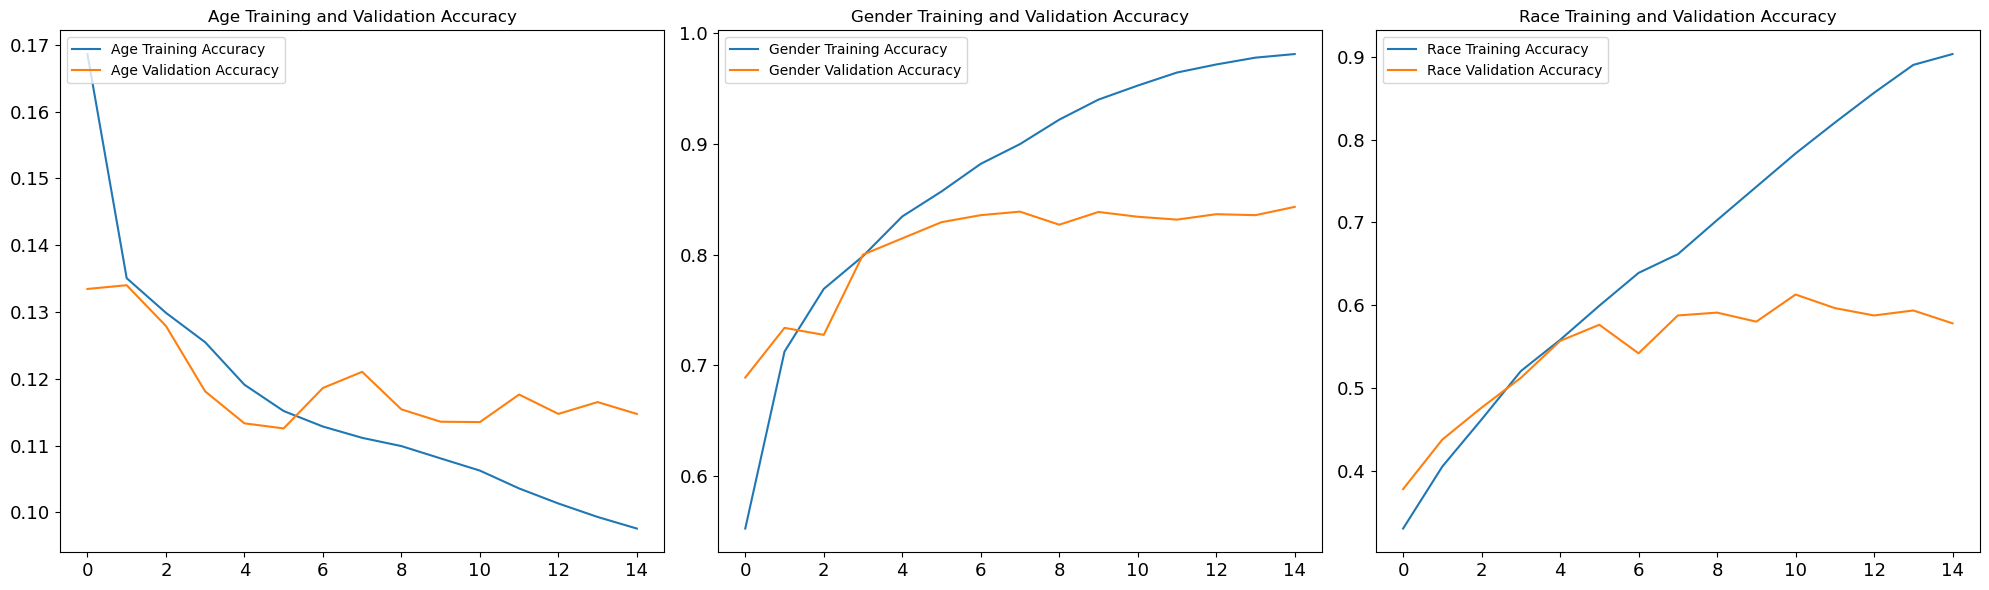

In [111]:

age_acc = history.history['age_output_mae']
age_val_acc = history.history['val_age_output_mae']

gender_acc = history.history['gender_output_accuracy']
gender_val_acc = history.history['val_gender_output_accuracy']

race_acc = history.history['race_output_accuracy']
race_val_acc = history.history['val_race_output_accuracy']




epochs_range = range(epochs)


fig, axs = plt.subplots(1, 3, figsize=(20, 6))


axs[0].plot(epochs_range, age_acc, label='Age Training Accuracy')
axs[0].plot(epochs_range, age_val_acc, label='Age Validation Accuracy')
axs[0].legend(loc='upper left')
axs[0].set_title('Age Training and Validation Accuracy')
axs[0].tick_params(axis='both', which='major', labelsize=13)  


axs[1].plot(epochs_range, gender_acc, label='Gender Training Accuracy')
axs[1].plot(epochs_range, gender_val_acc, label='Gender Validation Accuracy')
axs[1].legend(loc='upper left')
axs[1].set_title('Gender Training and Validation Accuracy')
axs[1].tick_params(axis='both', which='major', labelsize=13)  


axs[2].plot(epochs_range, race_acc, label='Race Training Accuracy')
axs[2].plot(epochs_range, race_val_acc, label='Race Validation Accuracy')
axs[2].legend(loc='upper left')
axs[2].set_title('Race Training and Validation Accuracy')
axs[2].tick_params(axis='both', which='major', labelsize=13)  

plt.tight_layout()
plt.show()



# Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


C:\Users\janma\AppData\Local\Temp\ipykernel_14472\3042663064.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Pred: {int(age_pred * 93)},{gender_map[gender_pred.argmax()]},{race_map[race_pred.argmax()]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


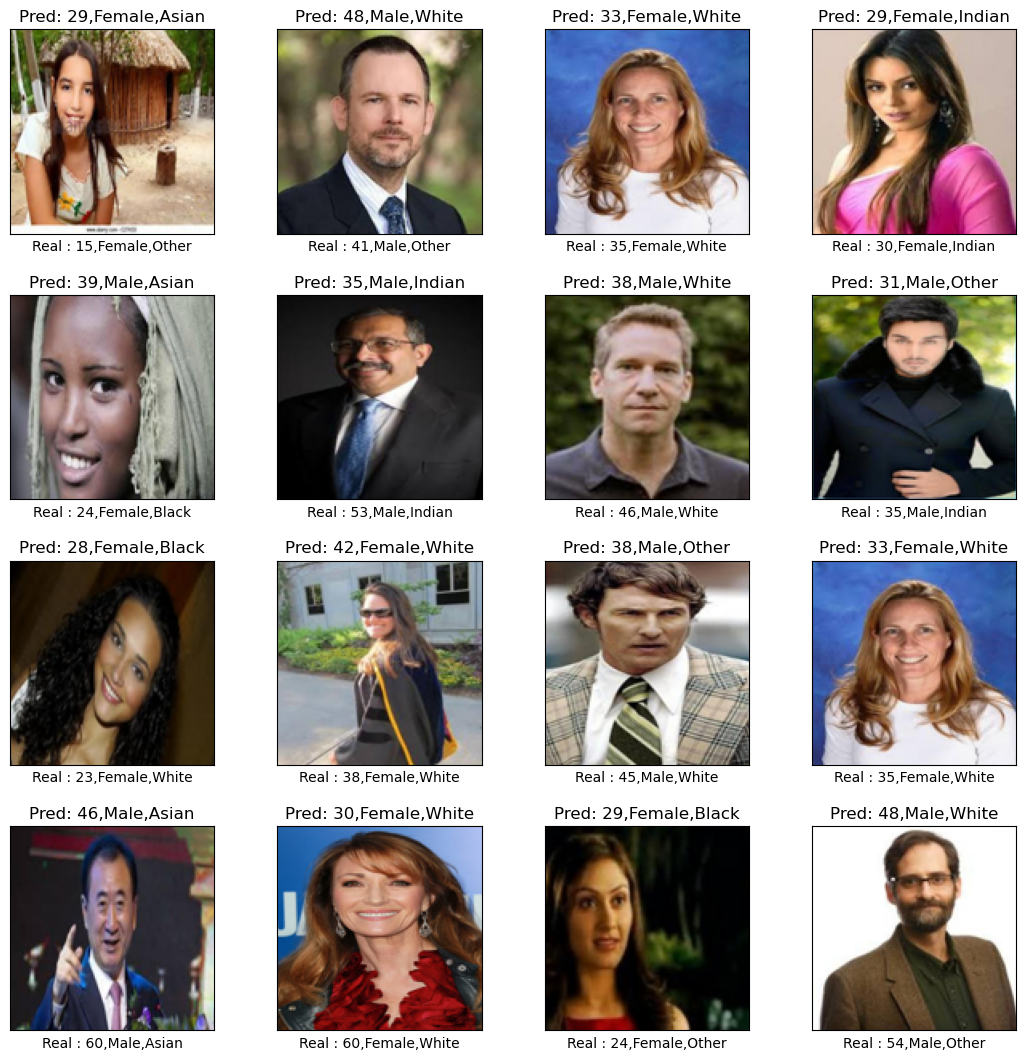

In [95]:
plt.figure(figsize=(13,13))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
for i in range(16):
    random_index = random.randint(0,len(df_test)-1)
    ax = plt.subplot(4,4,i+1)
    df_row = df_test.iloc[random_index]
    img = Image.open(os.path.join(dataset_path,df_row['Image']))
    plt.xlabel(f"Real : {df_row['Age']},{gender_map[df_row['Gender']]},{race_map[df_row['Race']]}")
    img_array = img.resize((img_width,img_height))
    plt.imshow(img_array)
    img_array = img_array.convert('RGB')
    img_array = np.array(img_array) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    race_pred, gender_pred, age_pred = model.predict(img_array)
    plt.title(f"Pred: {int(age_pred * 93)},{gender_map[gender_pred.argmax()]},{race_map[race_pred.argmax()]}")
    plt.xticks([])
    plt.yticks([])
    